# Разработка новой скважины.

Наша компания _ГлавРосГосНефть_ ищет новое место для бурения скважины. 

__Цель проекта:__

Необходимо выбрать 500 точек, из которых будут отобраны 200 лучших для разработки с вероятностью убытков менее 2,5%. 

__Ход проекта:__

- Загрузим и изучим данные;
- Построим модель для предсказания объема запасов в новых скважинах;
- Выберем скважины с самыми высокими оценками значений;
- Определим региона с максимальной сумарной прибылью отобранных скважин.ин.

## Шаг первый. Загрузка и подготовка данных.

### 1.1 Установка и импорт необходимых библиотек и их модулей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import warnings
import sklearn

warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

TEST_SIZE = 0.25
RANDOM_STATE = 42

### 1.2 Загрузка и обзор данных.

In [3]:
area_1 = pd.read_csv('geo_data_0.csv')
area_2 = pd.read_csv('geo_data_1.csv')
area_3 = pd.read_csv('geo_data_2.csv')

dfs = [area_1, area_2, area_3]

In [4]:
def data_rew(df):
    display(df.head(3))
    df.info()

for i in range(len(dfs)):
    data_rew(dfs[i])

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### 1.4 Работа с индексами.

_Установим признак 'id' в качестве индекса поскольку он не несет пользы для моделирования. Проверим что все id уникаьны что бы не возникло проблем с индексированием_

In [5]:
print(f'Уникальных id в датасете:{area_1["id"].nunique()}')
print(f'Уникальных id в датасете:{area_2["id"].nunique()}')
print(f'Уникальных id в датасете:{area_3["id"].nunique()}')

Уникальных id в датасете:99990
Уникальных id в датасете:99996
Уникальных id в датасете:99996


_Удалим дубликаты что бы использовать id как индексы_

In [6]:
area_1['id'] = area_1['id'].drop_duplicates()
area_1 = area_1.dropna()
area_2['id'] = area_2['id'].drop_duplicates()
area_2 = area_2.dropna()
area_3['id'] = area_3['id'].drop_duplicates()
area_3 = area_3.dropna()

In [7]:
area_1 = area_1.set_index('id')
area_2 = area_2.set_index('id')
area_3 = area_3.set_index('id')

display(area_1.head(2))
display(area_2.head(2))
display(area_3.head(2))

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.22117,105.280062
2acmU,1.334711,-0.340164,4.36508,73.037750


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697


### 1.5 Исследовательский анализ признаков.

_Убедимся что в данных нет выбросов и аномальных значений_

In [8]:
def num_describe(df, data):
    figure, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
    figure.suptitle(f'Распределение значений признака {data}')
    axes[0].set_title('"Ящик с усами"')
    axes[1].set_title('Гистограмма')
    sns.boxplot(ax=axes[0], data=df, x=data, palette='tab20b')
    sns.histplot(ax=axes[1], data=df, x=data, color='indigo', common_norm=True)
    plt.ylabel('Частота')

#### Первый регион

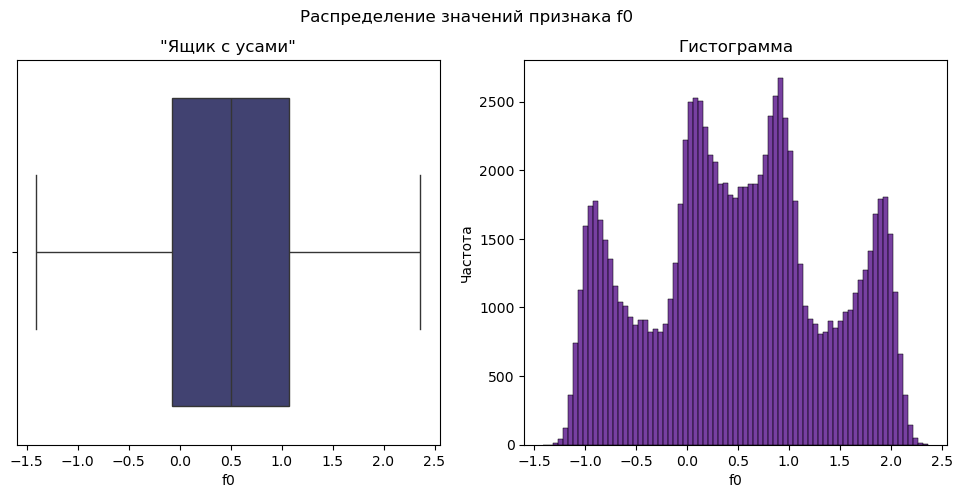

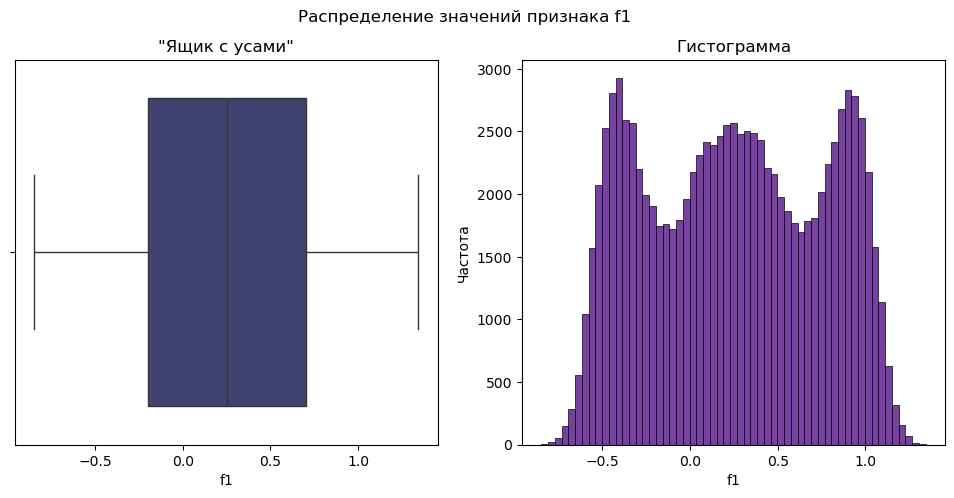

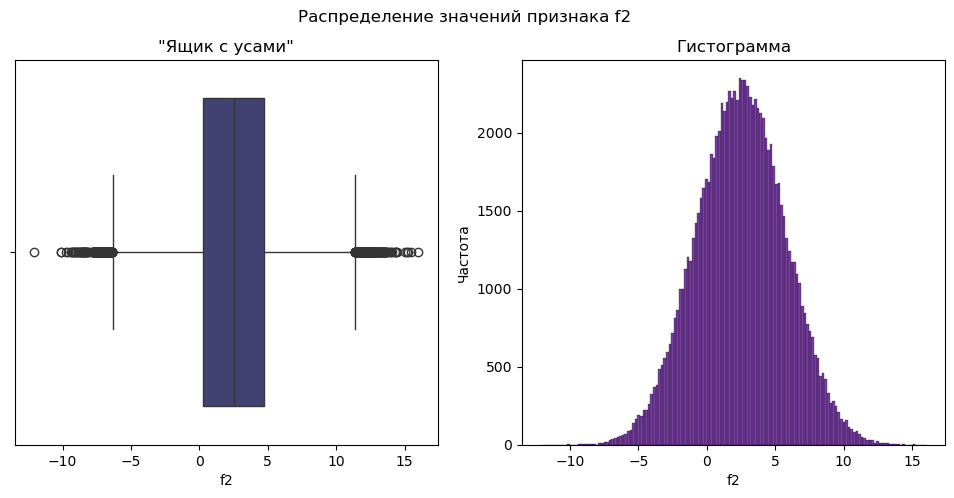

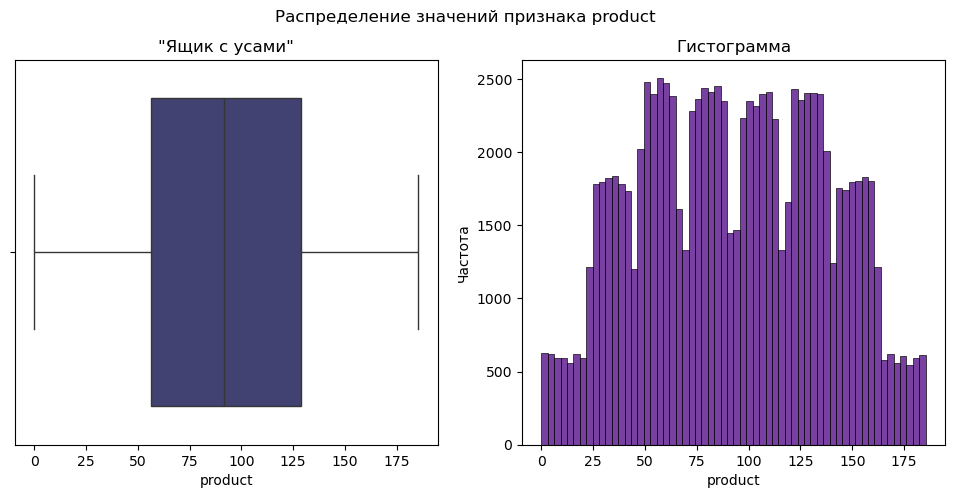

In [9]:
for i in range(len(area_1.columns)):
    num_describe(area_1, area_1.columns[i])

#### Второй регион

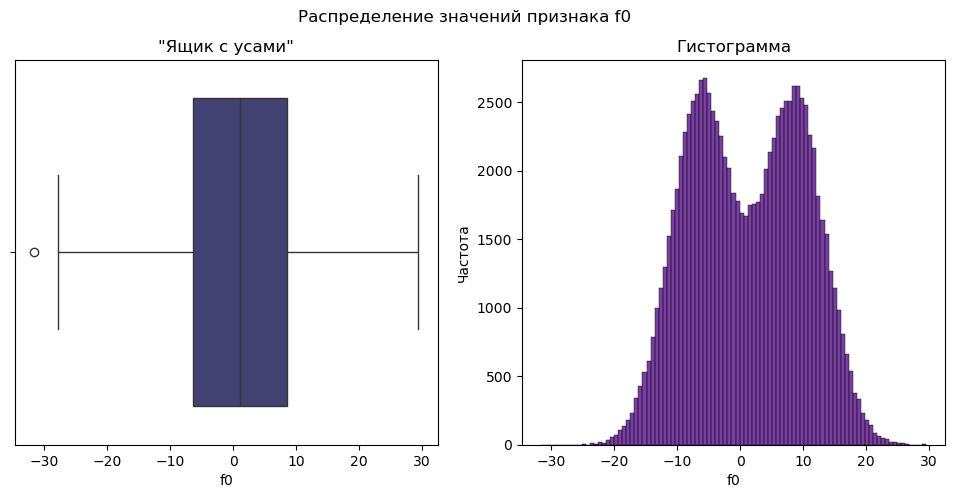

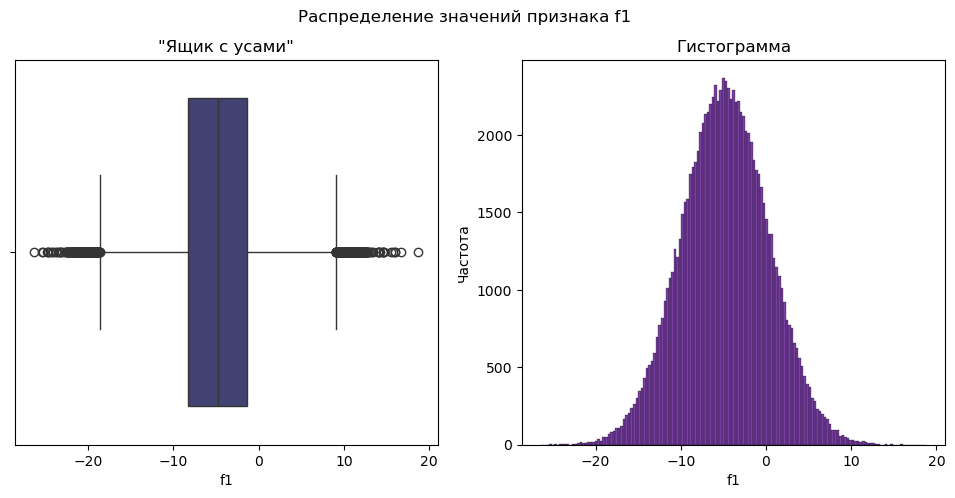

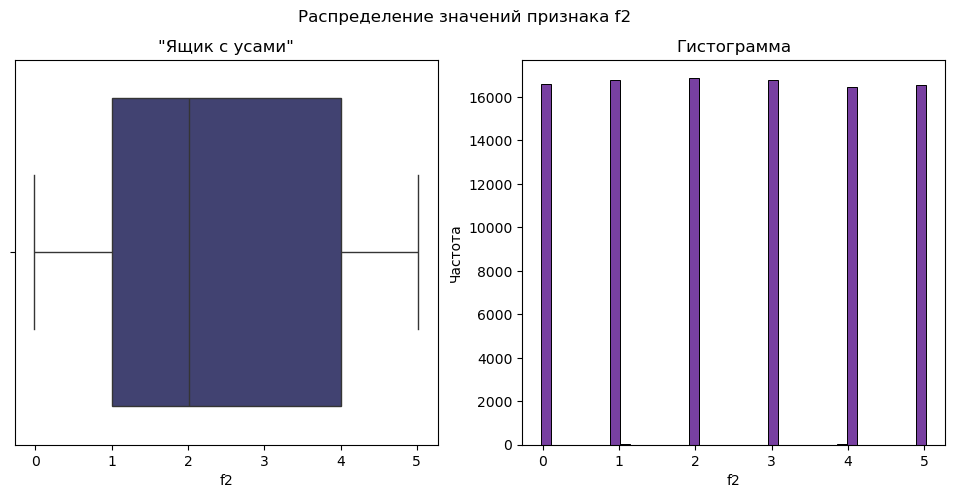

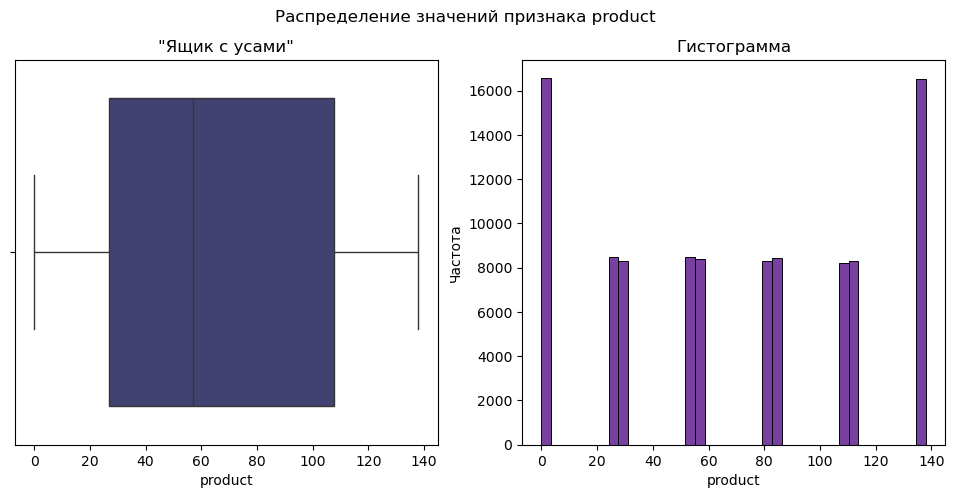

In [10]:
for i in range(len(area_2.columns)):
    num_describe(area_2, area_2.columns[i])

#### Третий регион

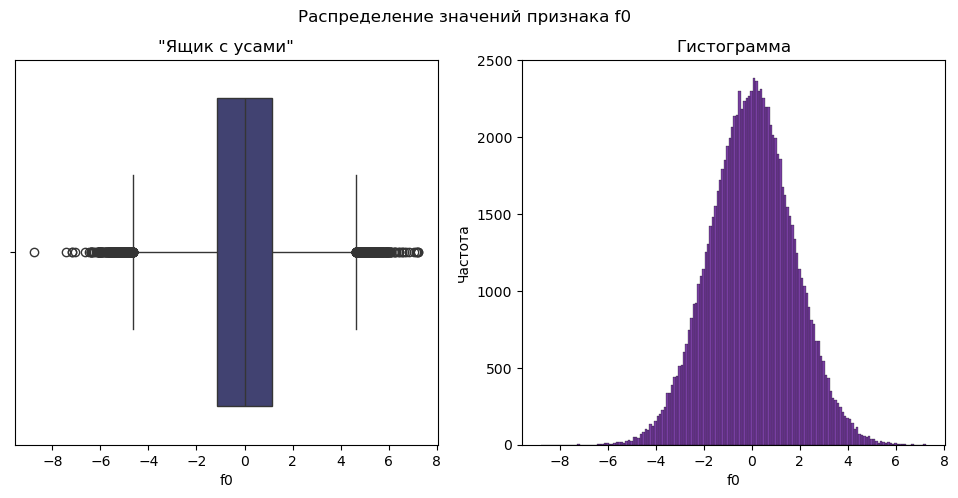

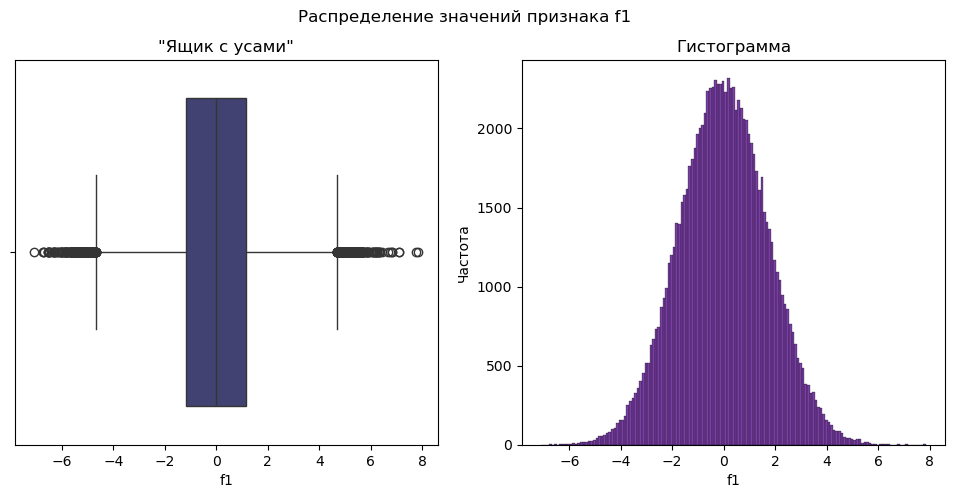

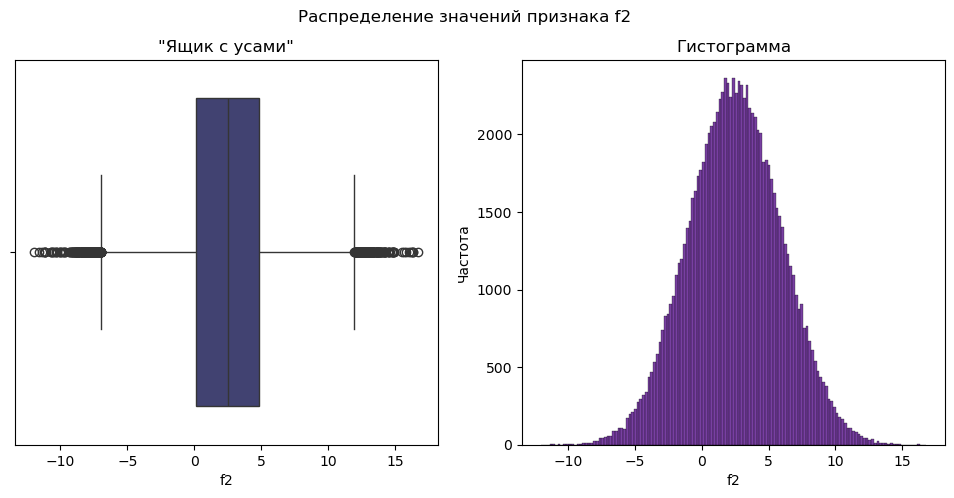

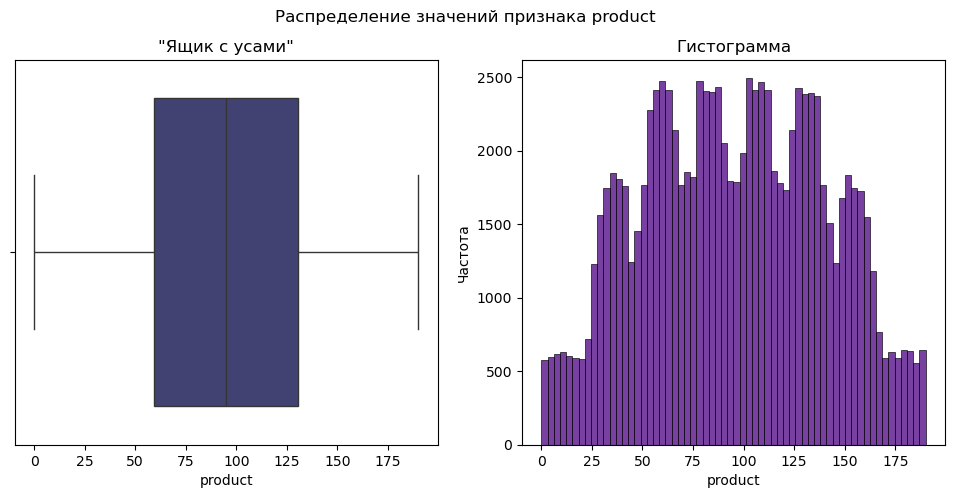

In [11]:
for i in range(len(area_3.columns)):
    num_describe(area_3, area_3.columns[i])

### 1.6 Корялиционный анализ.

_Рассмотрим взаимосвязь признаков_

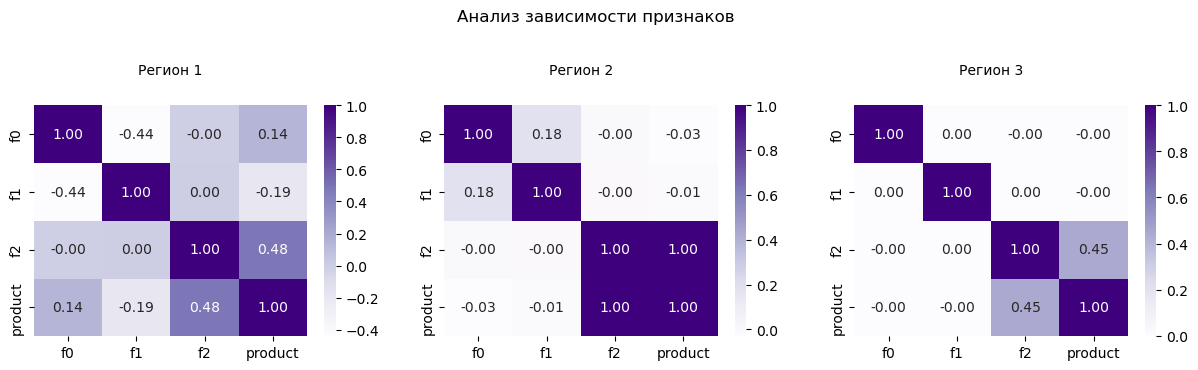

In [12]:
plt.figure(figsize=(15,3))
plt.suptitle('Анализ зависимости признаков', y=1.2)

dfs = [area_1, area_2, area_3]

for i in range(len(dfs)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(dfs[i].corr(), 
                annot=True, 
                fmt='.2f', 
                cmap="Purples")
    plt.title(f'Регион {i+1}', fontsize=10, y=1.1);

__Выводы по шагу:__

- Данные и библиотеки успешно загружены
- В данных нет пропусков, все колонки имеют корректный тип данных
- Из датасетов удалены повторяющиееся id, сам признак установлен в качестве индекса
- В данных отсутсвуют аномалии и выбросы
- Признак product во втором датасете почти полностью состоит из дубликатов, но по скольку данные синтетические, оставим его без изменений
- Изучена взаимосвязь признаков в данных, во втором датасете присутсвует мультиколиниарность из-за дубликатов. 

## Шаг второй. Моделирование.

### 1.1 Создание пайплайна и функций.

_Упрости процесс моделирования, создадим пайплайн возврщающий готовую модель, функцию для разделения датасета на тренировочную и валидационные выборки, функцию для оценки модели_

In [13]:
def pipe_maker(columns):
    
    data_preprocessor = ColumnTransformer(
        [
            ('num', StandardScaler(), columns)
        ], 
        remainder='passthrough'
     )
    pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)
    return pipe_final

In [14]:
def linreg_qualiti(y_test, y_pred):   

    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred, squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    
    x = y_test - y_pred

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(x=x, bins=50, color='indigo')
    plt.title('Распределение остатков модели')
    plt.xlabel('Ошибка модели')
    plt.ylabel('Частота')
    
    plt.subplot(1 ,2, 2)
    sns.scatterplot(x=y_pred, y=x, alpha=0.3, c='indigo')
    plt.grid()
    plt.title('Дисперсия остатков модели')
    plt.ylabel('Ошибка модели')
    plt.xlabel('Прогноз модели')
    
    return (
        print('Метрики модели:'), 
        print(f'R2 модели = {r2:.3f}'), 
        print(f'MAE модели = {mae:.3f}'),
        print(f'MSE модели = {mse:.3f}'), 
        print(f'RMSE модели = {rmse:.3f}'),
    )

In [15]:
def train_val_split(df, target):
    
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE)
    
    return X_train, X_valid, y_train, y_valid

### 1.2 Предсказания запасов сырья.

#### Первый регион

Метрики модели:
R2 модели = 0.275
MAE модели = 31.033
MSE модели = 1420.166
RMSE модели = 37.685


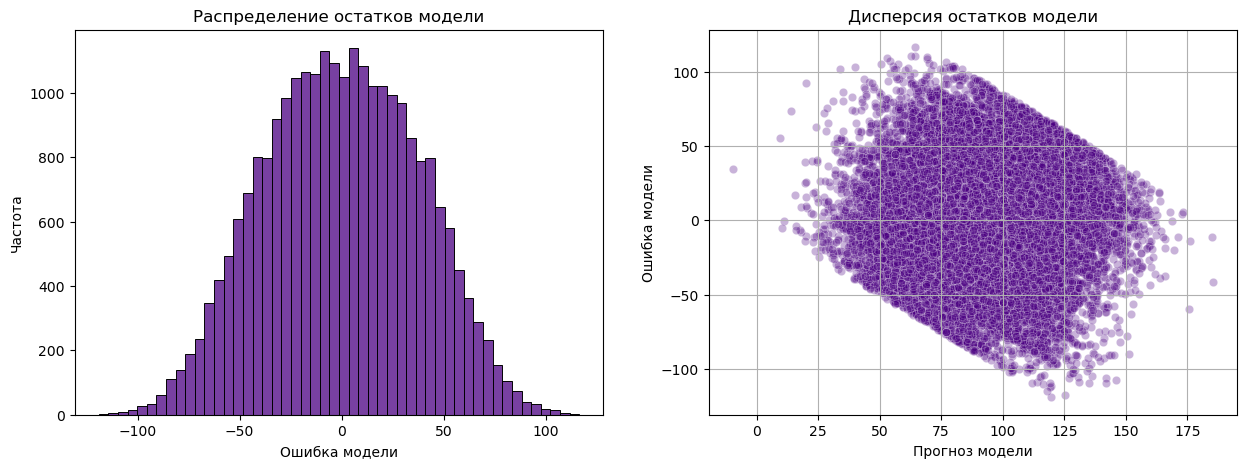

In [16]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_val_split(area_1, 'product')

model = pipe_maker(X_train_1.columns).fit(X_train_1, y_train_1)
y_pred_1 = model.predict(X_valid_1)

X_valid_1['preds'] = y_pred_1

linreg_qualiti(y_valid_1, y_pred_1);

#### Второй регион

Метрики модели:
R2 модели = 1.000
MAE модели = 0.718
MSE модели = 0.797
RMSE модели = 0.893


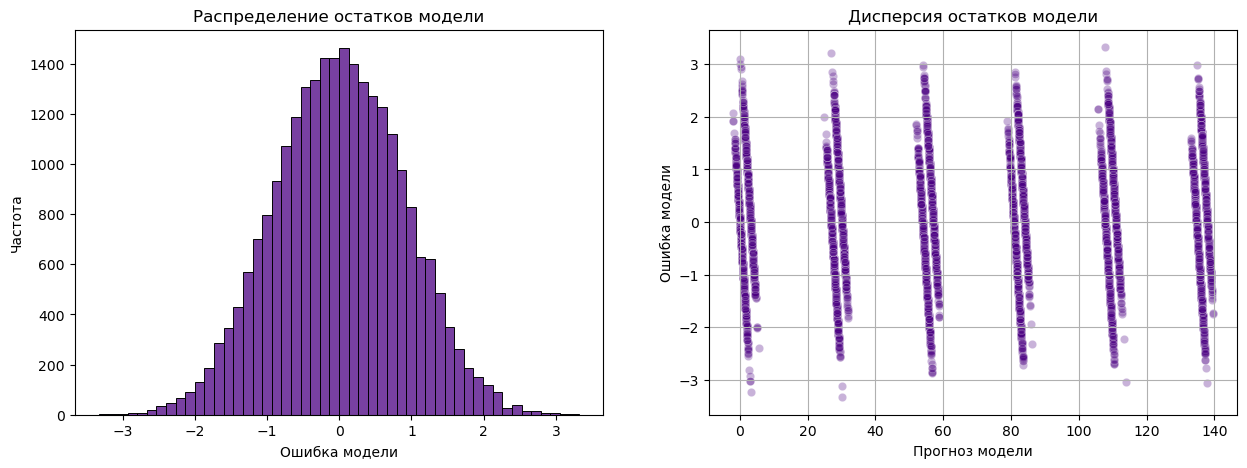

In [17]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_val_split(area_2, 'product')

model = pipe_maker(X_train_2.columns).fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_valid_2)

X_valid_2['preds'] = y_pred_2

linreg_qualiti(y_valid_2, y_pred_2);

#### Третий регион

Метрики модели:
R2 модели = 0.195
MAE модели = 32.839
MSE модели = 1606.472
RMSE модели = 40.081


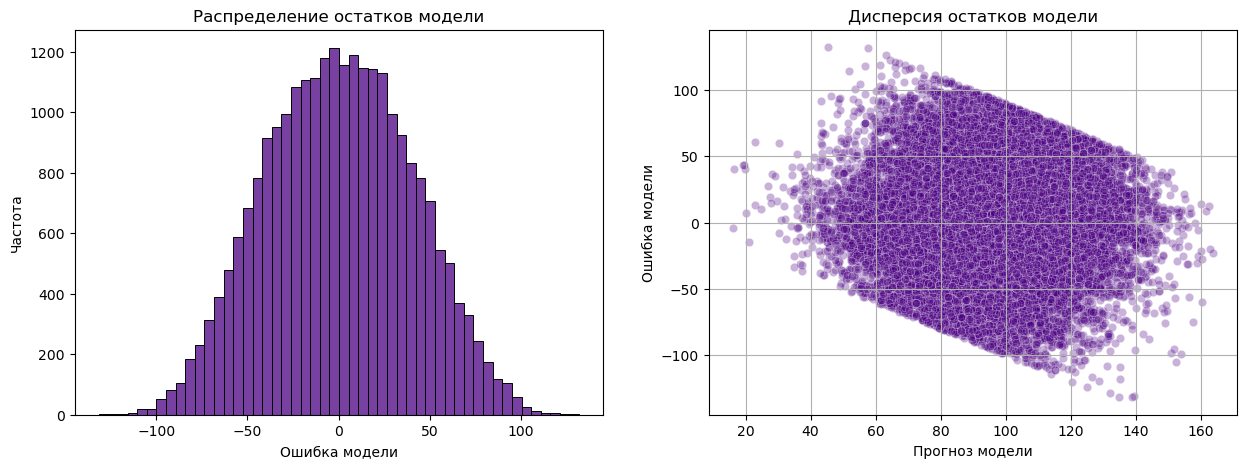

In [18]:
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_val_split(area_3, 'product')

model = pipe_maker(X_train_3.columns).fit(X_train_3, y_train_3)
y_pred_3 = model.predict(X_valid_3)

X_valid_3['preds'] = y_pred_3

linreg_qualiti(y_valid_3, y_pred_3);

__Выводы по шагу:__

Наша ключевая метрика - RMSE, лучшая у второй модели, но стоит учитывать что она делает предсказания на данных с большим колличеством дубликатов, и если изучить диспресию остатков, делает предсказания только практически совпадающие с исходными значениями в датасете. В контексте этого, лучшей оказалась модель для первого региона. 

## Шаг третий. Подготовка к рассчету прибыли.

#### Ключевые данные для рассчета.

In [19]:
BUDGET = 10000000000 #Бюджет на разработку региона
WELLS_TOTAL = 500
WELLS = 200 #Колличество планируемых скважин для разработки
REVENUE = 450000 #Цена одной баррели

#### Рассчет достаточного объема сырья для безубыточной скважины.

In [20]:
profit_well = (BUDGET/WELLS)/REVENUE

print(f'Необходимое колличество баррелей для безубыточной скважины:{profit_well:.3f}')
print(f'Среднее колличество баррелей в первом регионе:{area_1["product"].mean():.3f}')
print(f'Среднее колличество баррелей в первом регионе:{area_2["product"].mean():.3f}')
print(f'Среднее колличество баррелей в первом регионе:{area_3["product"].mean():.3f}')

Необходимое колличество баррелей для безубыточной скважины:111.111
Среднее колличество баррелей в первом регионе:92.500
Среднее колличество баррелей в первом регионе:68.824
Среднее колличество баррелей в первом регионе:94.998


__Выводы по шагу:__

- Ключевые данные записаны в переменные
- Рассчитан необходимый объем баррелей для безубыточной скважины - 111.111 бар.
- Срдений запас баррелей в регионах оказался ниже этого значения, наименьшая разница у третьего. 

## Шаг четвертый. Рассчет прибыли по предсказаниям модели.

#### 1.1 Создание рассчетных функций

_Объеденим предсказания и их целевые значения для рассчета прибыли_

In [21]:
#Преобразуем данные в датафрейм
y_valid_1 = pd.DataFrame(y_valid_1)
y_valid_2 = pd.DataFrame(y_valid_2)
y_valid_3 = pd.DataFrame(y_valid_3)
#Объеденим данные
predicted_area_1 = X_valid_1.join(y_valid_1)
predicted_area_2 = X_valid_2.join(y_valid_2)
predicted_area_3 = X_valid_3.join(y_valid_3)
#Проверим что все получилось
display(predicted_area_1.head(5))
display(predicted_area_2.head(5))
display(predicted_area_3.head(5))

,f0,f1,f2,preds,product
id,,,,,
qoTP6,1.760123,0.602091,7.850248,127.486528,119.813252
fNYo7,0.948101,-0.601353,4.055264,116.465831,133.296862
KpTZ4,-0.721709,0.577912,-0.134307,66.041910,25.310435
vGX0w,-0.084550,0.907580,-2.972129,45.009390,65.422491
6N2oA,0.272074,0.818032,8.694180,124.535557,140.851476


,f0,f1,f2,preds,product
id,,,,,
XObi5,0.518707,-5.983575,0.001335,1.745635,0.000000
wc1b3,5.588148,-2.187963,5.003146,135.730891,134.766305
WEK62,18.826929,-2.119254,4.993071,133.539653,134.766305
1A2kd,-0.353690,-10.003708,0.998885,28.844517,30.132364
YqOc2,-9.755378,-2.236383,5.006190,138.037182,137.945408


,f0,f1,f2,preds,product
id,,,,,
fEtM4,-1.349641,3.092185,5.414776,111.540811,156.925842
ZUTtd,-2.312980,1.702764,-2.386952,66.812289,31.245818
VtpnE,3.021226,-0.322292,-1.739777,70.406921,48.478519
qju6o,0.500312,-1.925757,-3.053501,63.118690,34.079047
FbzYP,-2.202068,2.999640,10.552605,141.162178,138.077543


_Напишем функцию считающую прибыль у лучших предсказанных скважин по целевому значению их признака_

In [22]:
def calculate_revenue(df):
    product_sum = (df
                   .sort_values('preds', ascending=False)
                   .head(WELLS)['product']
                   .sum())
    return product_sum * REVENUE - BUDGET

_И функцию которая с помощью Bootstrap находить распределение прибыли_

In [23]:
def bootstrap(df):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        random_wells = df.sample(n = WELLS_TOTAL, replace = True, random_state = state)
        values.append(calculate_revenue(random_wells))

    revenues = pd.Series(values)
    revenue_mean = round(int(revenues.mean()),2)
    lower = revenues.quantile(q=0.025)
    upper = revenues.quantile(q=0.975)
    risk = len(revenues[revenues <0]) / len(revenues)*100
    return revenues, revenue_mean, lower, upper, risk

### 1.2 Рассчет финансовых показателей по регионам.

_Получим и проанализируем значения_

In [24]:
revenues_1, revenue_mean_1, lower_1, upper_1, risk_1 = bootstrap(predicted_area_1)
revenues_2, revenue_mean_2, lower_2, upper_2, risk_2 = bootstrap(predicted_area_2)
revenues_3, revenue_mean_3, lower_3, upper_3, risk_3 = bootstrap(predicted_area_3)

_Создадим функцию которая поможет проанализировать регионы_

In [25]:
def area_revenue_score(revenues, revenue_mean, lower, upper, risk, x, y, z):
    print(f'95%-й доверительный интервал для первого региона: {lower} ; {upper}')
    print(f'Средняя прибыль первого региона: {revenue_mean}')
    print(f'Риск понести убытки: {risk:.2f}%')

    sns.histplot(data=revenues/10**6, color='indigo')
    plt.xlabel('Млн. рублей')
    plt.ylabel('Частота')
    plt.title('Анализ прибыльности региона', y=1.1)
    plt.axvline(x=revenue_mean/10**6, color='lime')
    plt.axvline(x=lower/10**6, color='red')
    plt.axvline(x=upper/10**6, color='red')
    plt.text(x, 25, 'доверительный интервал', rotation=90, color='red')
    plt.text(y, 25, 'доверительный интервал', rotation=90, color='red')
    plt.text(z, 40, 'Cредняя прибыль', rotation=90, color='lime');

#### Первый регион

95%-й доверительный интервал для первого региона: -96261928.01843758 ; 933493095.4996519
Средняя прибыль первого региона: 417354353
Риск понести убытки: 5.90%


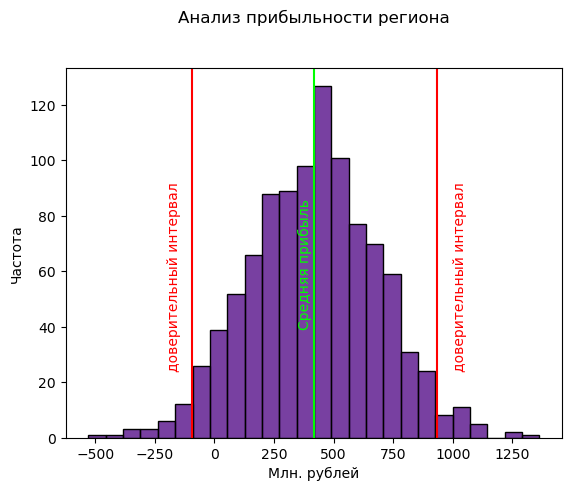

In [26]:
area_revenue_score(revenues_1, revenue_mean_1, lower_1, upper_1, risk_1, -200, 1000, 350)

#### Второй регион

95%-й доверительный интервал для первого региона: 51741836.3252449 ; 863042250.0217923
Средняя прибыль первого региона: 432017870
Риск понести убытки: 1.00%


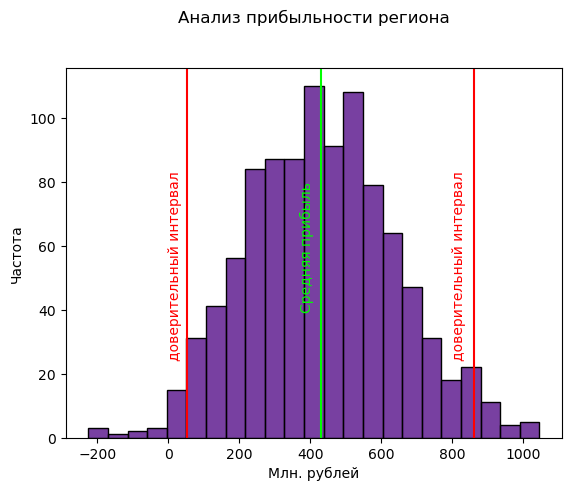

In [27]:
area_revenue_score(revenues_2, revenue_mean_2, lower_2, upper_2, risk_2, 0, 800, 370)

#### Третий регион

95%-й доверительный интервал для первого региона: -186256154.75548777 ; 892099105.6741308
Средняя прибыль первого региона: 356881964
Риск понести убытки: 8.90%


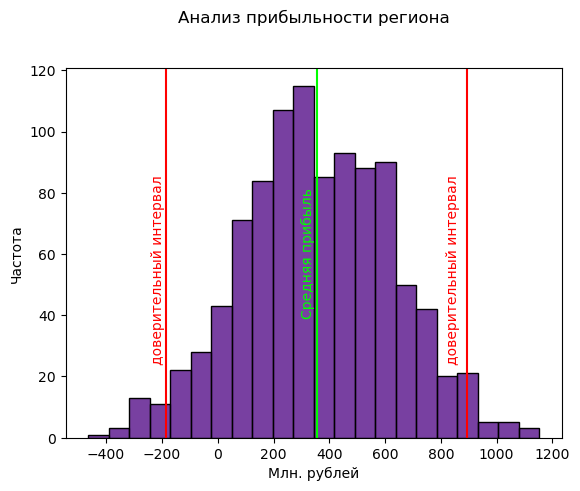

In [28]:
area_revenue_score(revenues_3, revenue_mean_3, lower_3, upper_3, risk_3, -240, 820, 300)

## Итоговый вывод

В ходе проекта мной были проделаны следующие шаги:

- Загрузка, предобработка, изучение данных
- Создание моделей предсказывающих объем запасов сырья для каждого из регионов
- Рассчитаны финансовые показатели для каждого из регионов
- Сделаны и описаны промежуточные выводы на кажлом этапе проекта

Установлено:

Из всех регионов по условиям задачи необходимо было выбрать тот, где риск уйти в убыток составляет менее 2,5%. Такое значение риска получил только второй регион(1%), а значит __второй регион следует выбрать для разработки сырья__. __95-й% довертильный интервал региона__ находится в диапазоне от 51 млн. до 863 млн. __Средняя прибыль по региону__: 432 млн. рублей. Так же модель делавшая предсказания по этому региону имеет лучшую __ключевую метрику RMSE__ - 0.893. 